# ODE System Identification with Monotonic Splines

The proposed method aims at a substantial speedup in exploring the fitness of large systems of ODEs w.r.t. provided full or partial data of variables' trajectories. These ODE systems are often found in physical and biochemical simulations. It is not feasible to expect a perfect qualitative match of a real physical system to its model variables' traces. Therefore, by exploring the fitness we mean the study of a Pareto-frontier in a space of per-variable fitness. Thus, as we are still aiming to attain the best fitness possible, we admit that, in general, we'll need to explore a top-K best fits of parameters w.r.t. the "closeness" of trajectories to the real data. The exploring may show that some variables are generally harder to fit than the others, which could yield improvements in the ODE model under study.

Preliminarily, the proposed method shows a possibility of attaining a representative sample of the referred Pareto-frontier with orders of magnitude fewer iterations, compute and time, as compared to a conventional approach of incorporating the solving of the ODE system along the calls of a fitness criterion being optimize

We are aware of the prior art in the area of dynamical systems parameter estimation, including the implementation in GEKKO library. For various reasons we could not obrain reliable operation of these implementations in our practice and given the size and complexity of operated ODE systems. We plan to pay more attention to comparing the prior art to proposed methods.d.

_Copyright (c) 2024: Dan Skaov_



In [1]:
# [1]
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.optimize import minimize, least_squares, Bounds
from scipy.integrate import solve_ivp
from typing import List
import random
import math
import pandas as pd;
from numba import jit

C:\Users\x1\AppData\Local\Temp\ipykernel_8936\1594325113.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd;


## Parameters and settings

In [2]:
## Selection of fitness function: 'rmse' or 'mape'
OBJECTIVE_FUNCTION_TYPE = 'rmse'

# Number of points in t-grid for spline derivative estimation
NUM_DERIVATIVE_POINTS = 30

# Number of t-points for plotting ODE solutions
NUM_PLOTTING_POINTS = 15

# Noise level for data trajectory
NOISE_LEVEL = 0.05

# Number of random starting points for optimization
NUM_RANDOM_STARTS = 10

# Timeout for each optimization in seconds
TIMEOUT = 120.0

# Spline type: 'pchip' or 'smooth'
SPLINE_TYPE = 'pchip'

# Smoothing factor for UnivariateSpline (only used if SPLINE_TYPE is 'smooth')
SMOOTHING_FACTOR = 0.1

In [3]:
# [2]
# Parameters
true_params = [2.5, 100.0, 6.0, 16.0, 100.0, 1.28, 12.0, 1.8, 13.0, 4.0, 0.52, 0.1, 1.0, 4.0]
param_names = ['J0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k', 'K', 'q', 'K1', 'psi', 'N_', 'A']

# Initial conditions
true_initial_conditions = [0.40, 1.50, 0.14, 0.20, 0.20, 1.00, 0.07]
variable_names = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

# Time points for simulation
t_start = 0.0
t_end = 1.0
t_points = np.linspace(t_start, t_end, NUM_PLOTTING_POINTS)

In [4]:
# [3]
# Define the ODE function in Python
@jit(nopython=True)
def yeast_ode(t, S, P):
    S1, S2, S3, S4, S5, S6, S7 = S
    J0, k1, k2, k3, k4, k5, k6, k, K, q, K1, psi, N_, A = P
    dS1 = J0 - k1*S1*S6/(1+(S6/K1)**4)
    dS2 = 2*k1*S1*S6/(1+(S6/K1)**4) - k2*S2*(N_-S5) - k6*S2*S5
    dS3 = k2*S2*(N_-S5) - k3*S3*(A-S6)
    dS4 = k3*S3*(A-S6) - k4*S4*S5 - K*(S4-S7)
    dS5 = k2*S2*(N_-S5) - k4*S4*S5 - k6*S2*S5
    dS6 = -2*k1*S1*S6/(1+(S6/K1)**4) + 2*k3*S3*(A-S6) - k5*S6
    dS7 = psi*K*(S4-S7) - k*S7
    return [dS1, dS2, dS3, dS4, dS5, dS6, dS7]

In [5]:
# [4]
# Solve the ODE problem to get the 'true' trajectory
def yeast_ode_wrapper(t, S):
    return yeast_ode(t, S, true_params)

sol = solve_ivp(yeast_ode_wrapper, [t_start, t_end], true_initial_conditions, t_eval=t_points, method='RK45')
true_solution = sol.y.T  # Shape: (len(t_points), num_variables)

In [6]:
# [5]
# Generate 'data' trajectory
data_solution = true_solution.copy()

# Flip the first and third variables upside down
# data_solution[:, 0] = np.max(data_solution[:, 0]) - data_solution[:, 0] + np.min(data_solution[:, 0])
# data_solution[:, 2] = np.max(data_solution[:, 2]) - data_solution[:, 2] + np.min(data_solution[:, 2])

# Add small noise to other variables (excluding first and third)
for i in range(data_solution.shape[1]):
    if i not in [0, 2]:
        noise = NOISE_LEVEL * np.random.randn(len(t_points)) * np.abs(data_solution[:, i])
        data_solution[:, i] += noise

# Create splines for each variable
splines = []
for i in range(data_solution.shape[1]):
    if SPLINE_TYPE == 'pchip':
        spline = PchipInterpolator(t_points, data_solution[:, i])
    elif SPLINE_TYPE == 'smooth':
        spline = UnivariateSpline(t_points, data_solution[:, i], s=SMOOTHING_FACTOR)
    else:
        raise ValueError("Invalid SPLINE_TYPE. Choose 'pchip' or 'smooth'.")
    splines.append(spline)

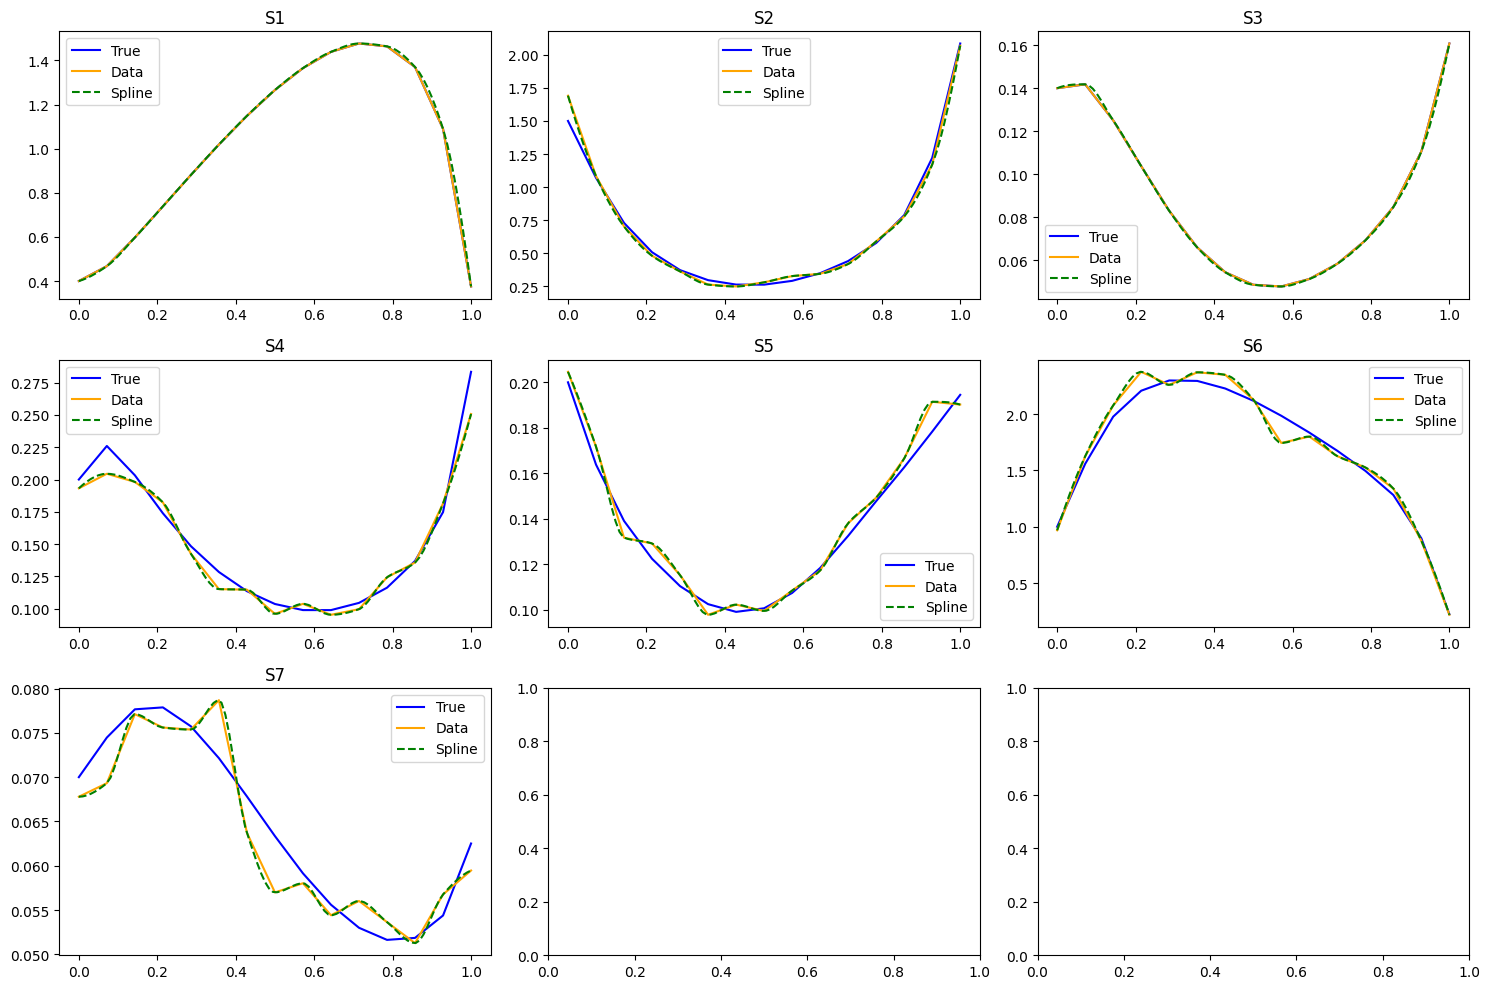

In [7]:
# [6]
# Plot the 'true' and 'data' trajectories, along with splines
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes[:7]):
    ax.plot(t_points, true_solution[:, i], label='True', color='blue')
    ax.plot(t_points, data_solution[:, i], label='Data', color='orange')
    
    # Plot spline
    t_spline = np.linspace(t_start, t_end, 100)
    ax.plot(t_spline, splines[i](t_spline), label='Spline', color='green', linestyle='--')
    
    ax.set_title(variable_names[i])
    ax.legend()

fig.tight_layout()
plt.show()

In [8]:
# [7]
# Define the ObjectiveFunction class
class ObjectiveFunction:
    def __init__(self, ode_system, data_solution, t_points, num_variables, objective_function_type=OBJECTIVE_FUNCTION_TYPE, timeout=TIMEOUT, lower_bounds=None, upper_bounds=None):
        self.ode_system = ode_system
        self.data_solution = data_solution
        self.t_points = t_points
        self.num_variables = num_variables
        self.objective_function_type = objective_function_type
        self.func_values = []
        self.per_variable_distances = []
        self.iterations = 0
        self.start_time = time.time()
        self.timeout = timeout
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds

    def __call__(self, params):
        if time.time() - self.start_time > self.timeout:
            raise TimeoutError("Objective function evaluation timed out.")

        # Check if params are within bounds
        if self.lower_bounds is not None and np.any(params < self.lower_bounds):
            return np.inf
        if self.upper_bounds is not None and np.any(params > self.upper_bounds):
            return np.inf

        self.iterations += 1
        num_initial_conditions = self.num_variables
        initial_conditions = params[:num_initial_conditions]
        ode_params = params[num_initial_conditions:]

        # Solve the ODE system
        try:
            def ode_system(t, S):
                return self.ode_system(t, S, ode_params)

            sol = solve_ivp(ode_system, [self.t_points[0], self.t_points[-1]], initial_conditions, t_eval=self.t_points, method='RK45')
            if not sol.success:
                return np.inf
            model_solution = sol.y.T  # Shape: (len(t_points), num_variables)
        except Exception as e:
            # If the ODE solver fails, return a high objective value
            return np.inf

        # Compute per-variable distances
        per_variable_distance = []
        for i in range(self.num_variables):
            data_seq = self.data_solution[:, i]
            model_seq = model_solution[:, i]

            # Scale data_seq to [0,1], per variable
            data_min = data_seq.min()
            data_max = data_seq.max()
            if data_max - data_min == 0:
                data_scaled = np.zeros_like(data_seq)
                model_scaled = np.zeros_like(model_seq)
            else:
                data_scaled = (data_seq - data_min) / (data_max - data_min)
                model_scaled = (model_seq - data_min) / (data_max - data_min)

            if self.objective_function_type == 'rmse':
                distance = np.sqrt(np.mean((data_scaled - model_scaled) ** 2))
            elif self.objective_function_type == 'mape':
                distance = np.mean(np.abs((data_scaled - model_scaled) / (data_scaled + 1.0)))
            else:
                raise ValueError("Invalid objective_function_type. Choose 'rmse' or 'mape'.")

            per_variable_distance.append(distance)

        objective_value = np.sum(per_variable_distance)
        self.func_values.append(objective_value)
        self.per_variable_distances.append(per_variable_distance)
        return objective_value

In [9]:
# [8]
# Function to plot trajectories
def plot_fit(result, method_name, fit_idx):
    x = result['x']
    initial_conditions = x[:len(true_initial_conditions)]
    ode_params = x[len(true_initial_conditions):]

    # Solve the ODE system
    def ode_system(t, S):
        return yeast_ode(t, S, ode_params)

    sol = solve_ivp(ode_system, [t_start, t_end], initial_conditions, t_eval=t_points, method='RK45')
    model_solution = sol.y.T  # Shape: (len(t_points), num_variables)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:7]):
        ax.plot(t_points, model_solution[:, i], label='Fitted', color='red')
        ax.plot(t_points, true_solution[:, i], label='True', color='blue')
        ax.plot(t_points, data_solution[:, i], label='Data', color='orange')
        ax.set_title(variable_names[i])
        ax.legend()

    fig.suptitle(f'{method_name} - Fit {fit_idx+1}', fontsize=16)
    plt.tight_layout()
    plt.show()


## Classical method: Parameter estimation using Nelder-Mead optimization starting from random points

In [10]:
# [9]
# Classical method
num_params = len(true_initial_conditions) + len(true_params)
param_bounds = []
for i in range(num_params):
    if i < len(true_initial_conditions):
        # For initial conditions
        val = true_initial_conditions[i]
    else:
        # For parameters
        val = true_params[i - len(true_initial_conditions)]
    lower = 0.1 * val
    upper = 10 * val
    param_bounds.append((lower, upper))

# No bounds for Nelder-Mead, but we can check bounds in the ObjectiveFunction
lower_bounds = np.array([b[0] for b in param_bounds])
upper_bounds = np.array([b[1] for b in param_bounds])

results = []

print("Starting Classical Method Optimization...")
start_time = time.time()
for idx in range(NUM_RANDOM_STARTS):
    # Generate random starting point in the hypercube
    x0 = [random.uniform(b[0], b[1]) for b in param_bounds]

    # Create an instance of the ObjectiveFunction
    obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names), lower_bounds=lower_bounds, upper_bounds=upper_bounds)

    try:
        res = minimize(obj_func, x0, method='Nelder-Mead', options={'maxiter': 1000})
        results.append({
            'x': res.x,
            'fun': res.fun,
            'per_variable_distances': obj_func.per_variable_distances[-1]
        })
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Objective Value = {res.fun}")
    except TimeoutError:
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Timeout")
        continue

end_time = time.time()
classical_method_time = (end_time - start_time) / 60  # Convert to minutes
print(f"Classical Method Optimization Completed in {classical_method_time:.2f} minutes.")

Starting Classical Method Optimization...
Iteration 1/10: Objective Value = 3.5820373085480606
Iteration 2/10: Objective Value = 4.697490448852968
Iteration 3/10: Objective Value = 10.01144735131023
Iteration 4/10: Objective Value = 5.755202853771579
Iteration 5/10: Objective Value = 3.965658690968282
Iteration 6/10: Objective Value = 8.207365643377102
Iteration 7/10: Objective Value = 6.724604213042353
Iteration 8/10: Objective Value = 11.074649402597656
Iteration 9/10: Objective Value = 6.300671192418851
Iteration 10/10: Objective Value = 3.572968674612505
Classical Method Optimization Completed in 4.16 minutes.


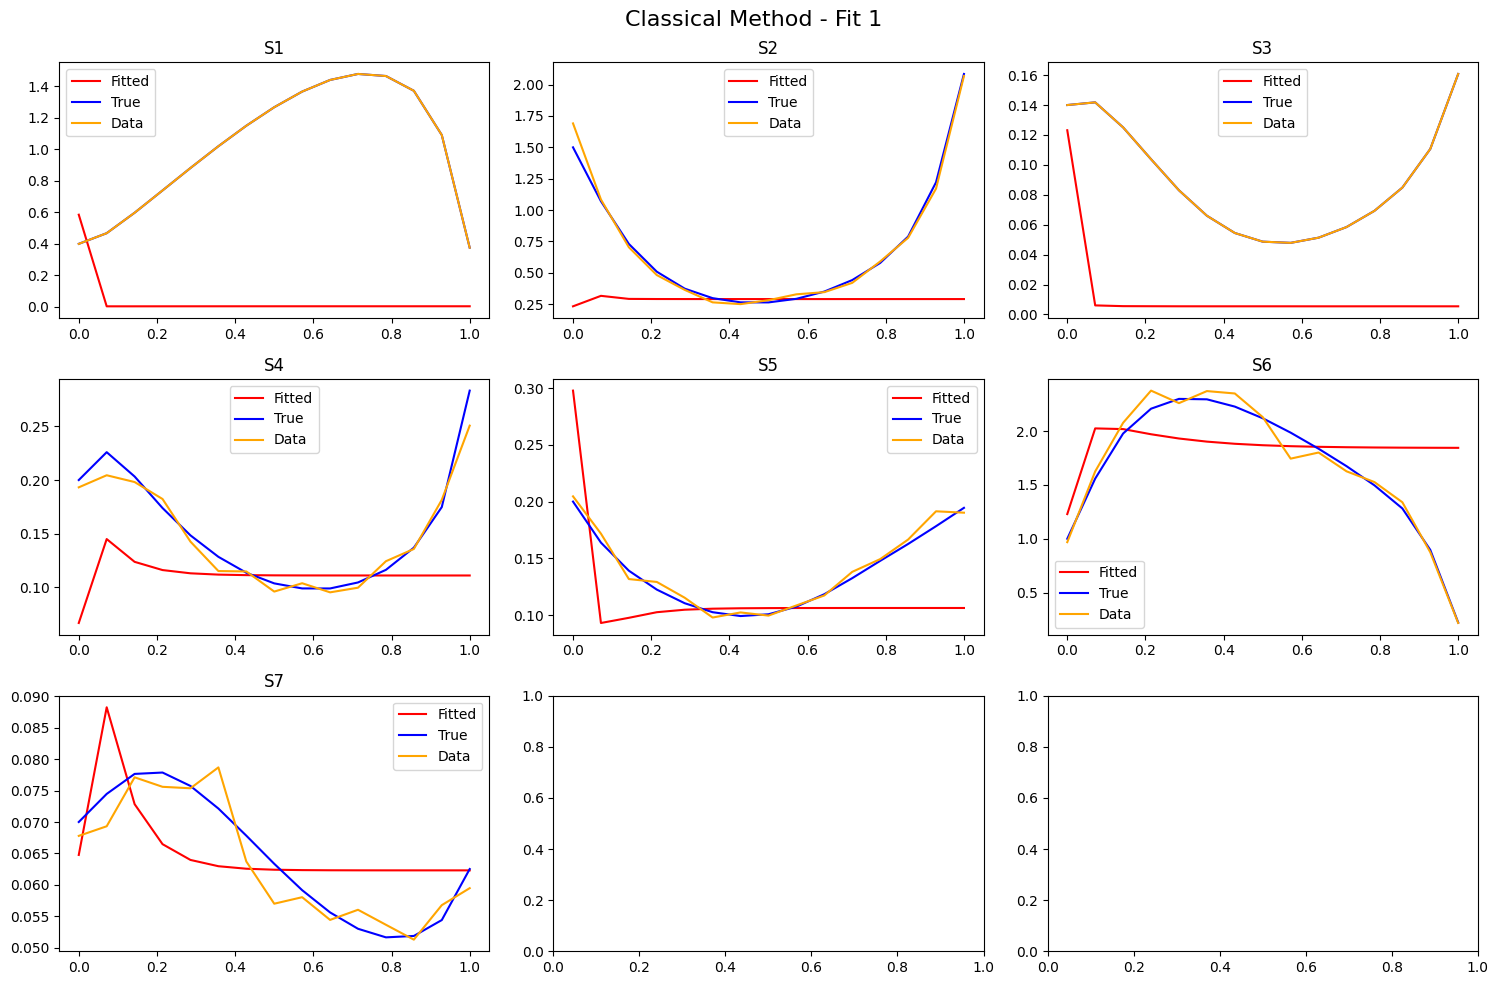

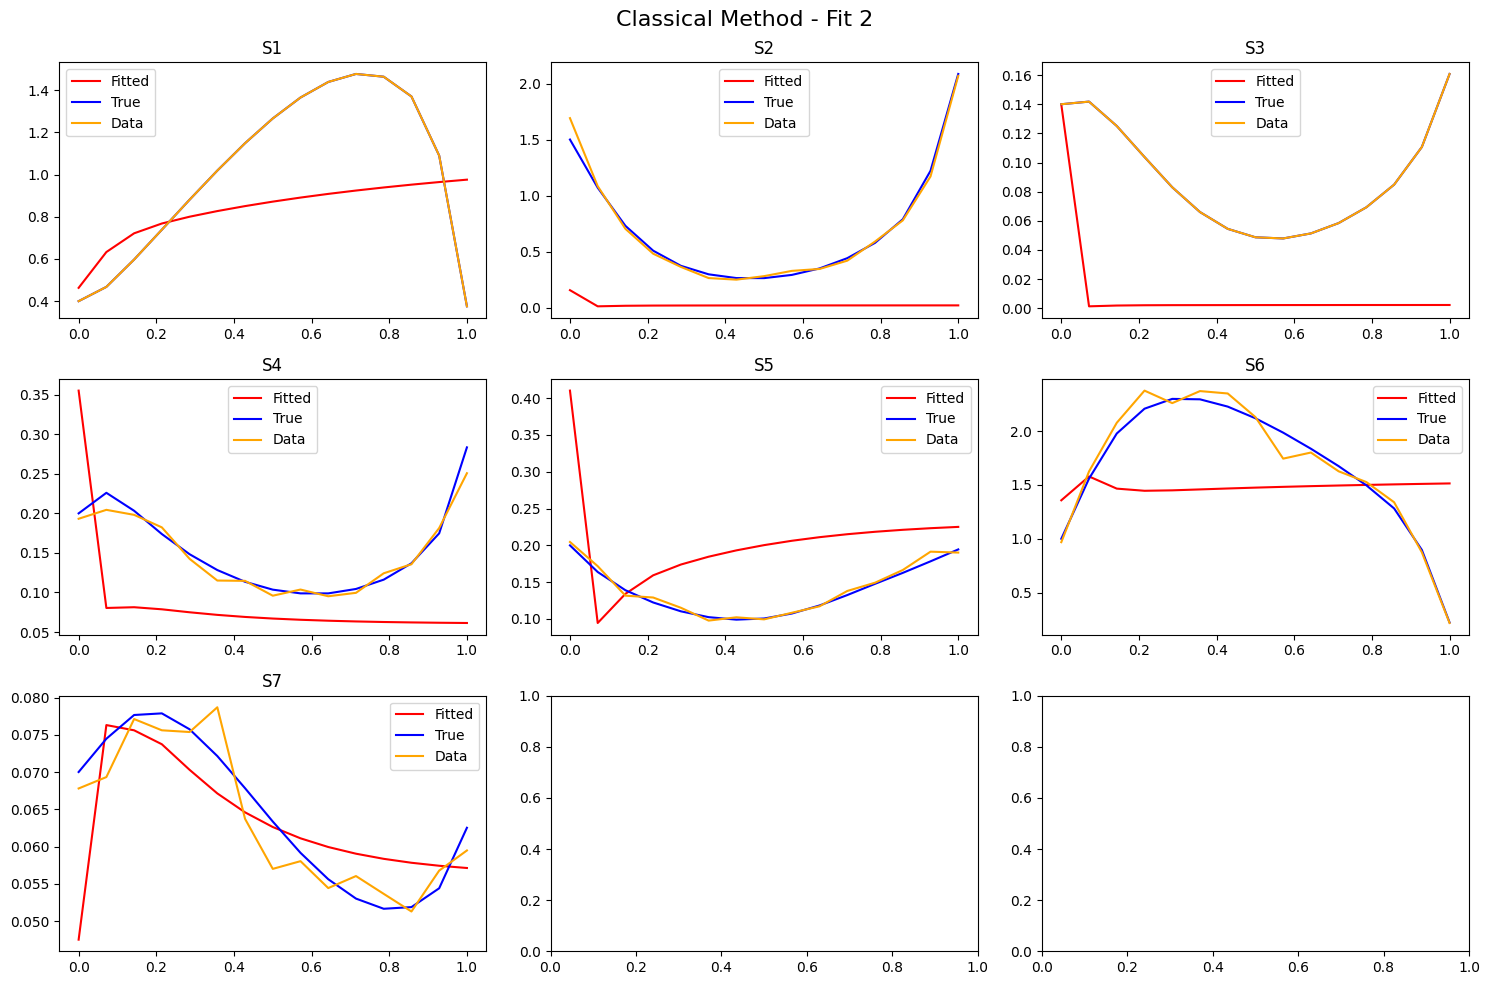

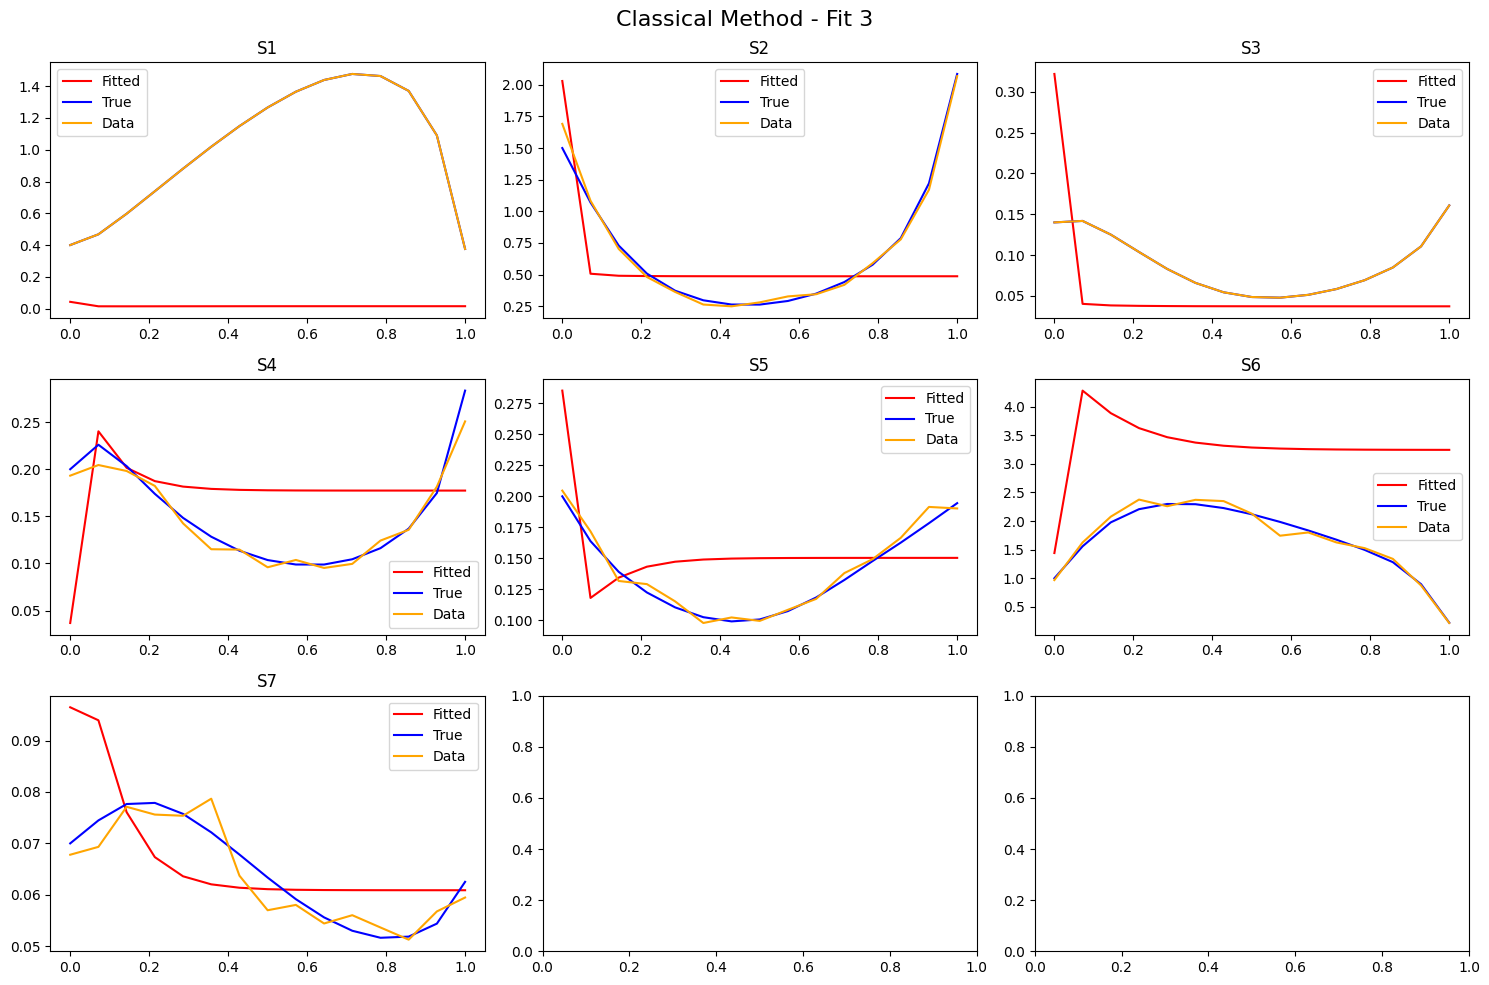

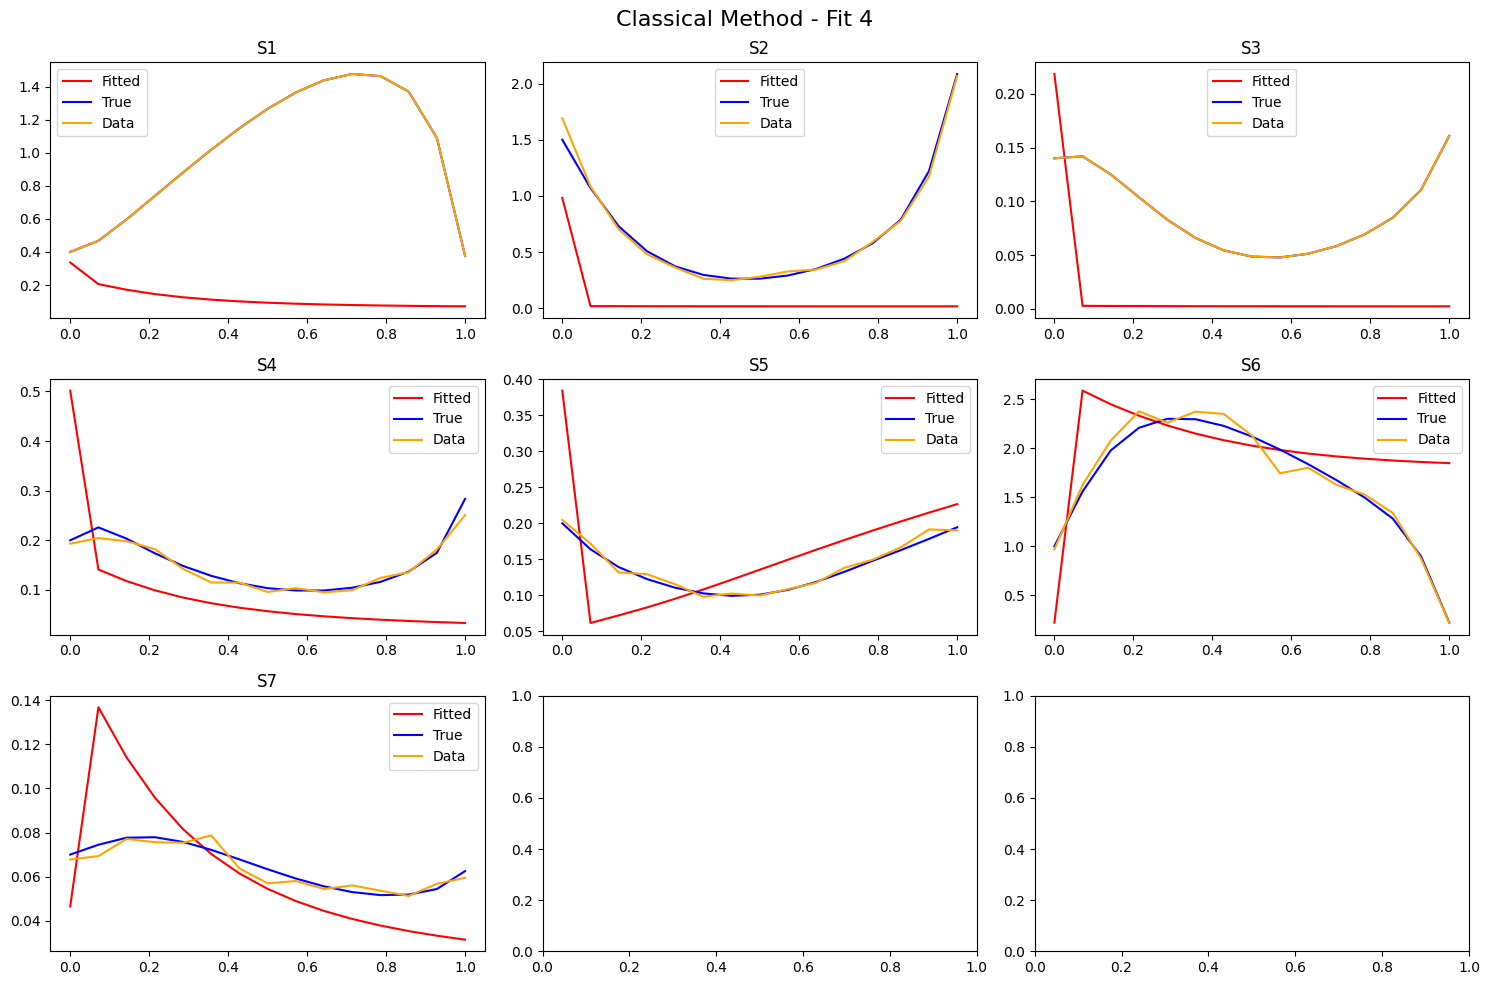

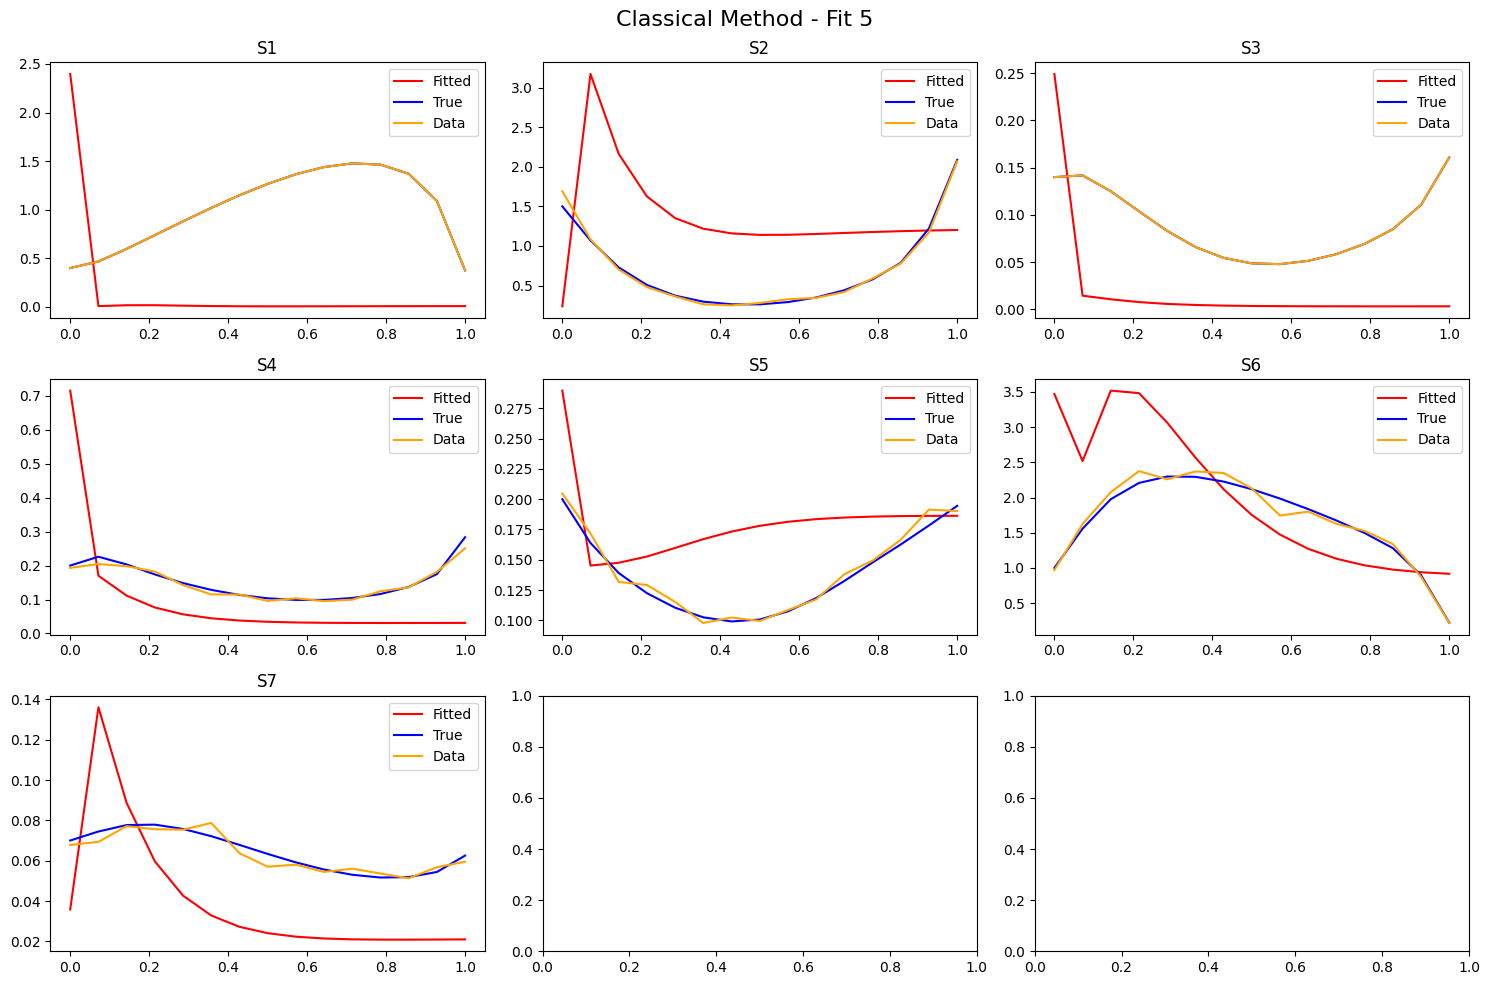

In [11]:
# [10]
# Sort the results by objective function value
sorted_results = sorted(results, key=lambda x: x['fun'])

# Plot the top 5 fits
for idx, result in enumerate(sorted_results[:5]):
    plot_fit(result, 'Classical Method', idx)

## Innovative method: Using PCHIP splines and derivative estimation to set up nonlinear equations

In [12]:
# [11]
# Innovative method
# Number of points for derivative estimation
t_grid = np.linspace(t_start, t_end, NUM_DERIVATIVE_POINTS)

# Prepare the data for the nonlinear system
derivatives = []
variable_values = []

for t in t_grid:
    vars_at_t = []
    derivs_at_t = []
    for spline in splines:
        vars_at_t.append(spline(t))
        derivs_at_t.append(spline.derivative()(t))
    variable_values.append(vars_at_t)
    derivatives.append(derivs_at_t)

variable_values = np.array(variable_values)  # Shape: (num_t_points, num_variables)
derivatives = np.array(derivatives)  # Shape: (num_t_points, num_variables)

In [13]:
# [13]
# Calculate the normalization factors for each equation
def calculate_spread():
    spreads = []
    for i in range(len(t_grid)):
        S = variable_values[i]
        dS_dt = derivatives[i]
        spreads.append(dS_dt)
    spreads = np.array(spreads)
    return np.min(spreads, axis=0), np.max(spreads, axis=0)

drv_min, drv_max = calculate_spread()

def residuals_function(P):
    residuals = []
    for i in range(len(t_grid)):
        S = variable_values[i]
        dS_dt = derivatives[i]
        f_S_P = yeast_ode(0, S, P)
        dS_dt_scaled = (dS_dt - drv_min) / (drv_max - drv_min)
        f_S_P_scaled = (f_S_P - drv_min) / (drv_max - drv_min)
        residual = (dS_dt - f_S_P)
        residuals.extend(residual)
    residuals = np.array(residuals)
    return residuals

# Bounds for parameters
param_bounds = []
for i in range(len(true_params)):
    val = true_params[i]
    lower = 0.1 * val
    upper = 10 * val
    param_bounds.append((lower, upper))

param_bounds = ([b[0] for b in param_bounds], [b[1] for b in param_bounds])

# Get initial conditions from spline at t=0
initial_conditions_innovative = []
for spline in splines:
    initial_conditions_innovative.append(spline(t_start))

In [14]:
drv_min

array([-13.0421589 , -10.082895  ,  -0.30386915,  -0.61062185,
        -0.71597482, -10.53642145,  -0.2454123 ])

In [15]:
 [14]
# Evaluate fitness for the innovative method
innovative_results = []

print("Starting Innovative Method Optimization...")
start_time = time.time()
for idx in range(NUM_RANDOM_STARTS):
    # Random initial guess for parameters
    P0 = [random.uniform(0.1 * val, 10 * val) for val in true_params]

    try:
        res = least_squares(residuals_function, P0, bounds=param_bounds)
        # Solve the ODE with estimated parameters and initial conditions
        ode_params = res.x
        initial_conditions = initial_conditions_innovative

        def ode_system(t, S):
            return yeast_ode(t, S, ode_params)

        sol = solve_ivp(ode_system, [t_start, t_end], initial_conditions, t_eval=t_points, method='RK45')
        if not sol.success:
            continue
        model_solution = sol.y.T  # Shape: (len(t_points), num_variables)

        # Compute objective function value
        obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names))
        fun_value = obj_func(np.concatenate([initial_conditions, ode_params]))

        innovative_results.append({
            'x': np.concatenate([initial_conditions, ode_params]),
            'fun': fun_value,
            'per_variable_distances': obj_func.per_variable_distances[-1]
        })
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Objective Value = {fun_value}")
    except Exception as e:
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Exception occurred - {str(e)}")
        continue
end_time = time.time()
innovative_method_time = (end_time - start_time) / 60  # Convert to minutes
print(f"Innovative Method Optimization Completed in {innovative_method_time:.2f} minutes.")

Starting Innovative Method Optimization...
Iteration 1/10: Objective Value = 1.442797877359432
Iteration 2/10: Objective Value = 1.4427976560793756
Iteration 3/10: Objective Value = 1.442797704902786
Iteration 4/10: Objective Value = 1.4427755257727684
Iteration 5/10: Objective Value = 1.4427004046593235
Iteration 6/10: Objective Value = 1.4427970697946226
Iteration 7/10: Objective Value = 1.4427977632914053
Iteration 8/10: Objective Value = 1.4427971718899588
Iteration 9/10: Objective Value = 1.4427942329184338
Iteration 10/10: Objective Value = 1.4427971290623933
Innovative Method Optimization Completed in 0.04 minutes.


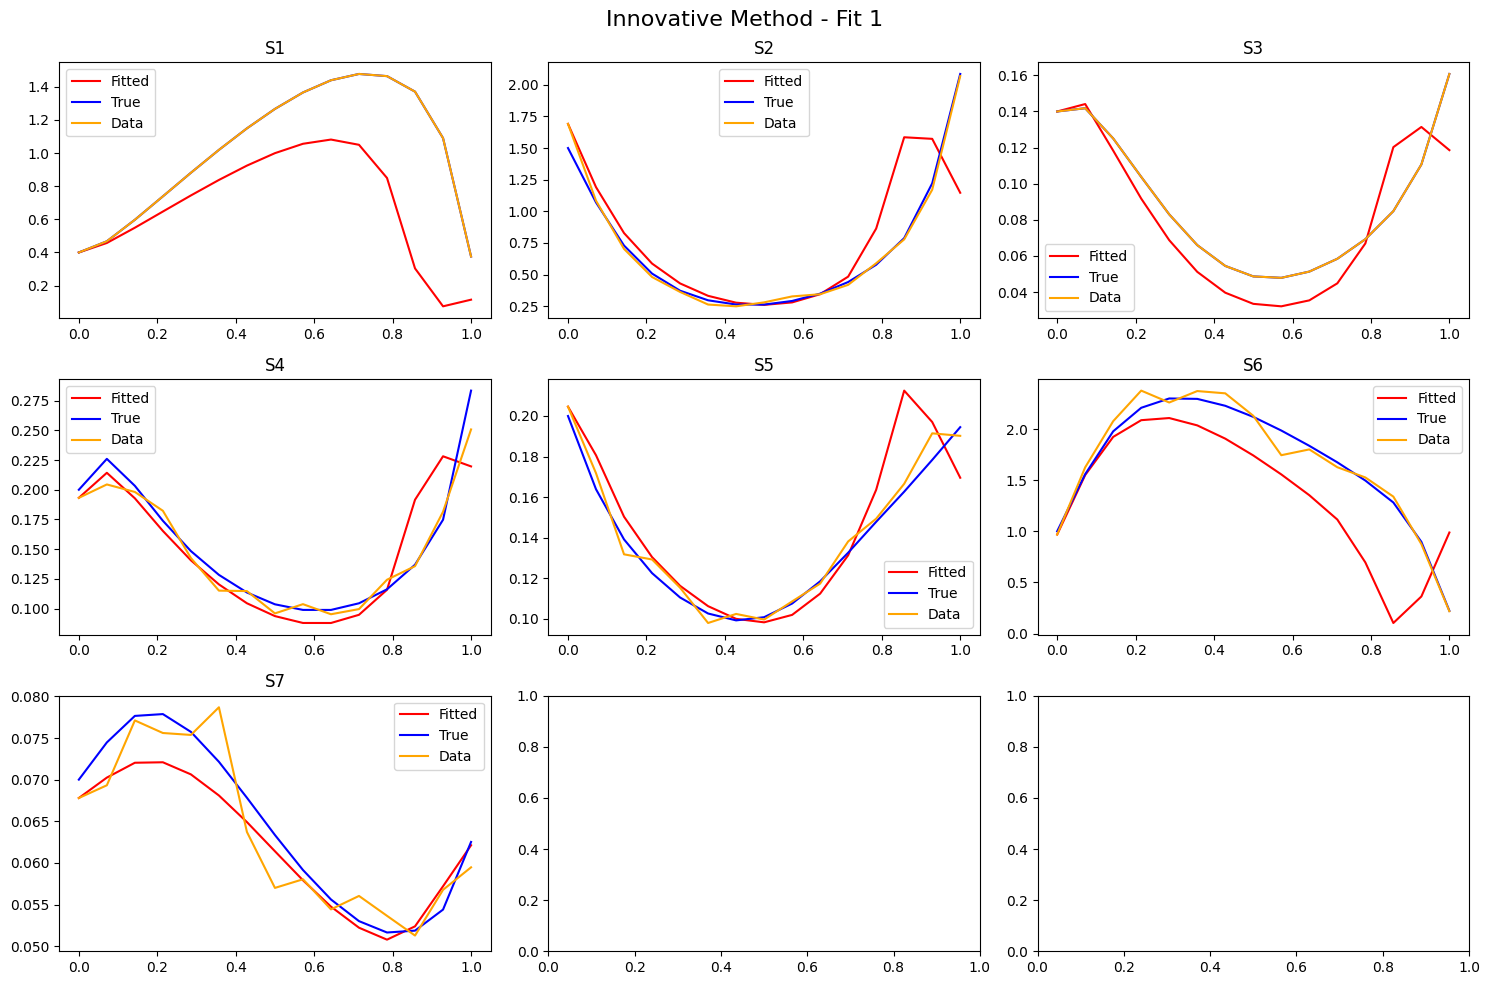

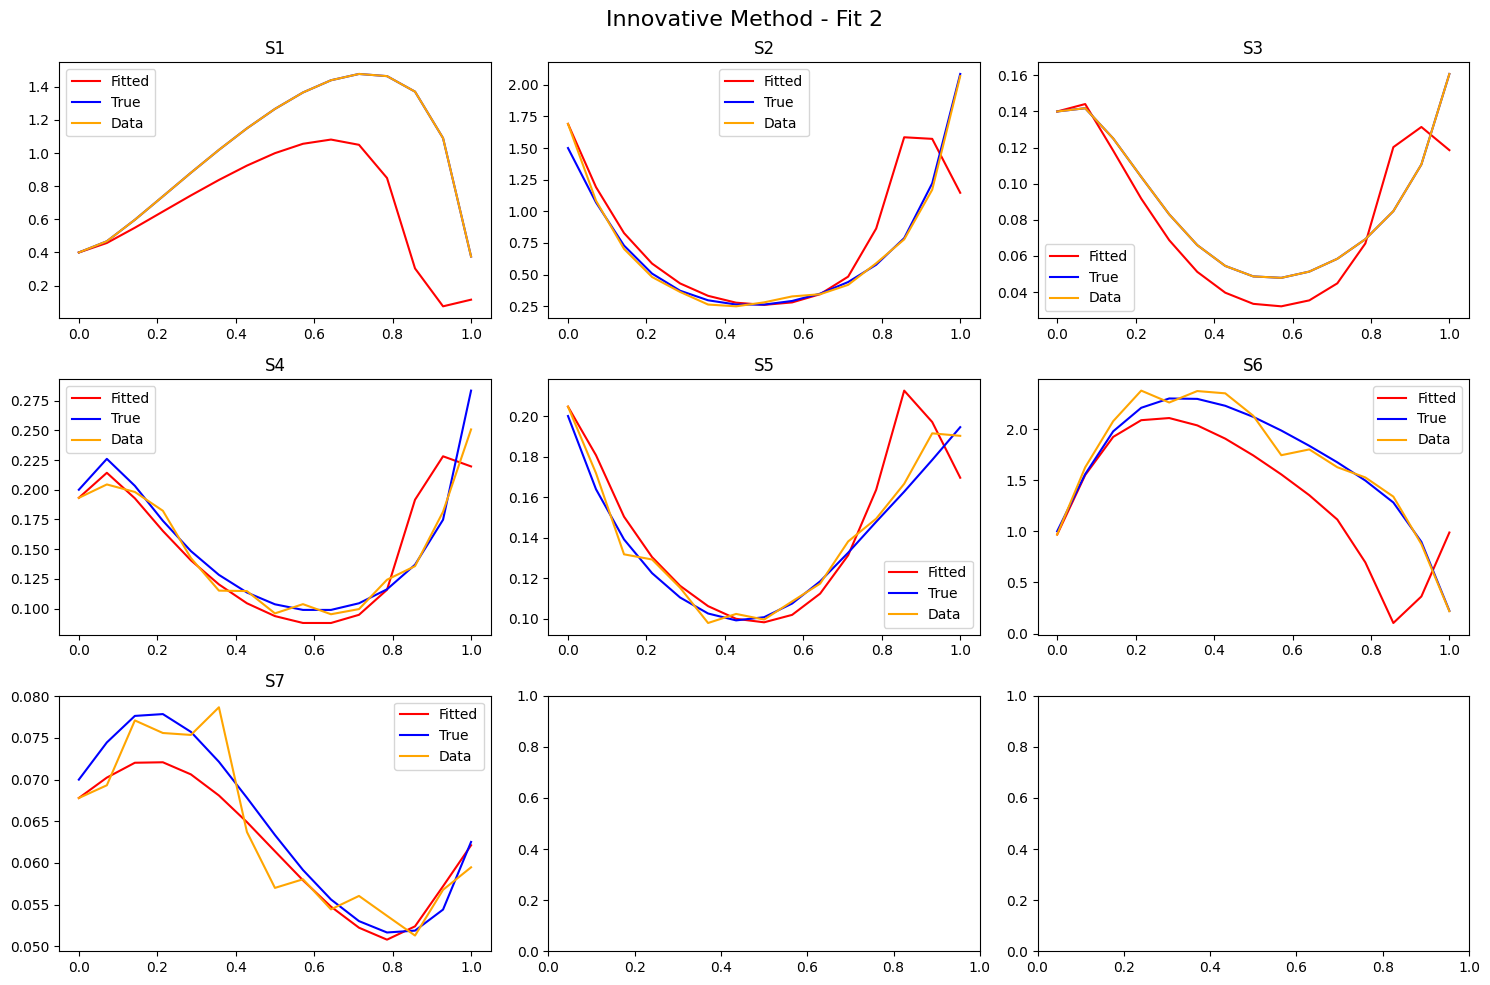

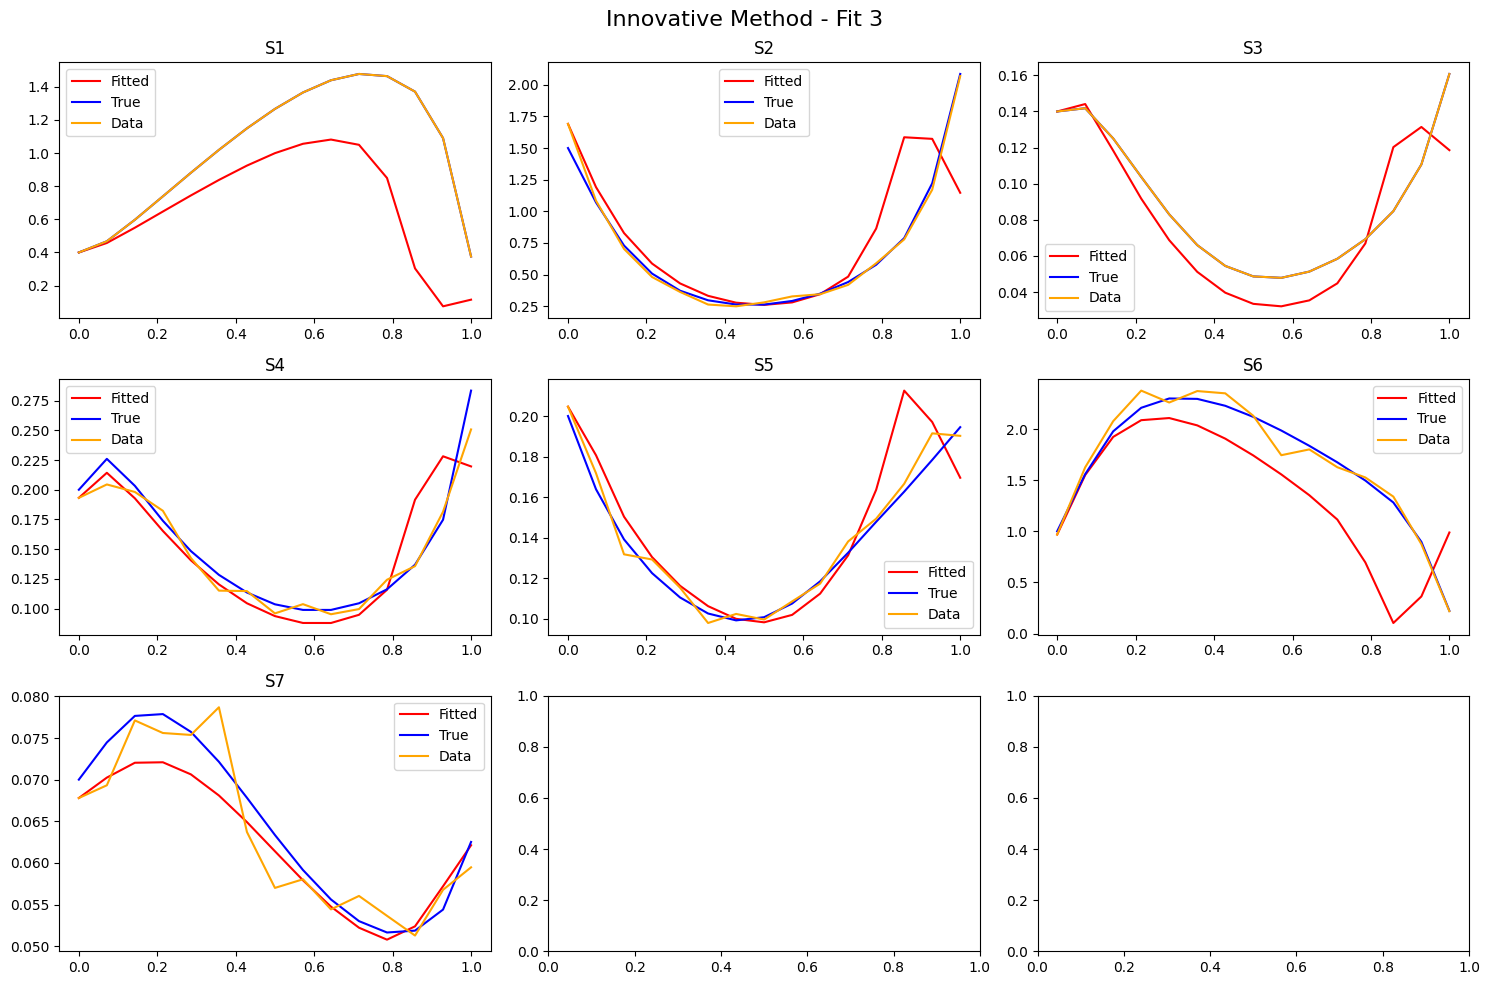

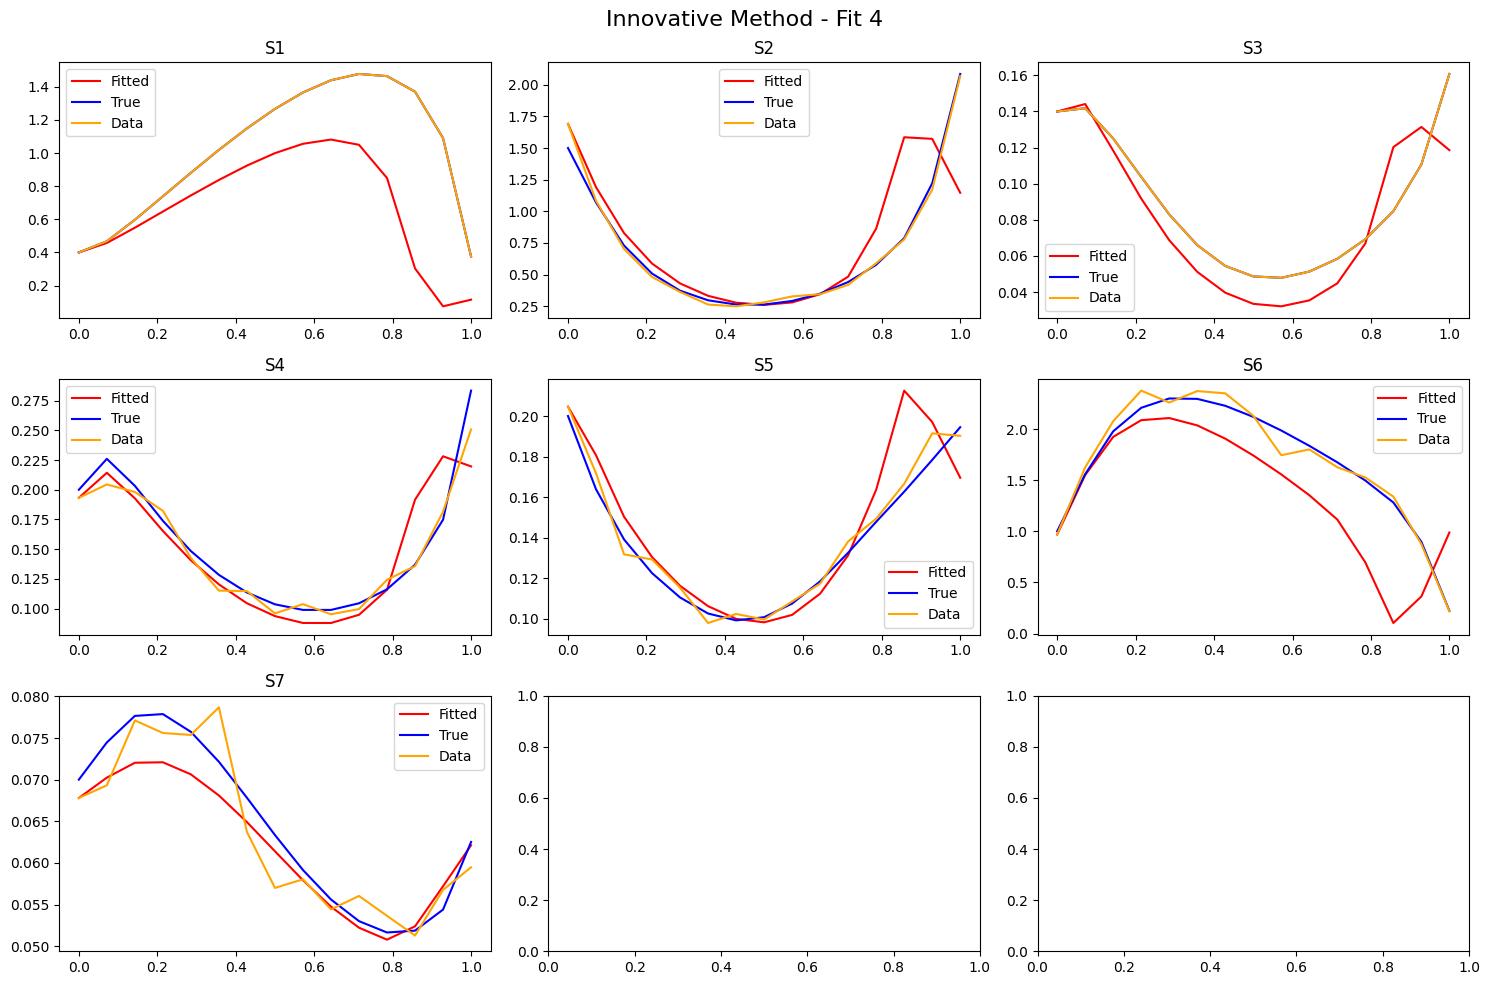

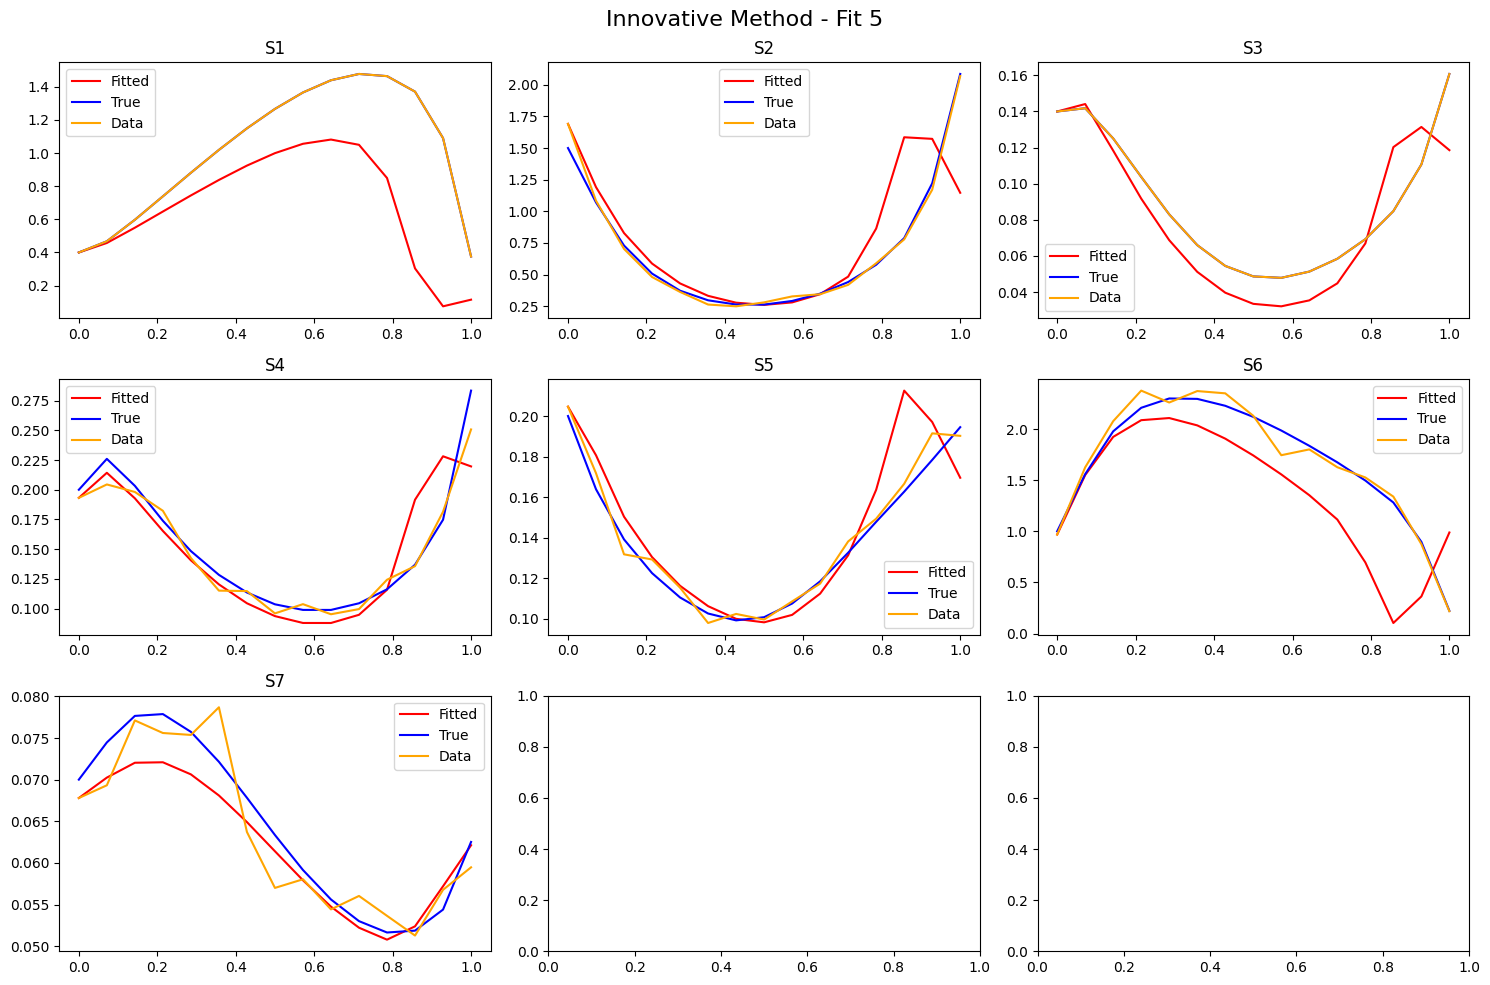

In [16]:
# [15]
# Sort the results by objective function value
sorted_innovative_results = sorted(innovative_results, key=lambda x: x['fun'])

# Plot the top 5 fits
for idx, result in enumerate(sorted_innovative_results[:5]):
    plot_fit(result, 'Innovative Method', idx)


## Hybrid method: Using solutions from the innovative method as starting points for the classical method

In [17]:
# [16]
# Hybrid method
hybrid_results = []

print("Starting Hybrid Method Optimization...")
start_time = time.time()
for idx, result in enumerate(innovative_results):
    x0 = result['x']

    # Create an instance of the ObjectiveFunction
    obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names), lower_bounds=lower_bounds, upper_bounds=upper_bounds)

    try:
        res = minimize(obj_func, x0, method='Nelder-Mead', options={'maxiter': 1000})
        hybrid_results.append({
            'x': res.x,
            'fun': res.fun,
            'per_variable_distances': obj_func.per_variable_distances[-1]
        })
        print(f"Iteration {idx+1}/{len(innovative_results)}: Objective Value = {res.fun}")
    except TimeoutError:
        print(f"Iteration {idx+1}/{len(innovative_results)}: Timeout")
        continue
end_time = time.time()
hybrid_method_time = (end_time - start_time) / 60  # Convert to minutes
print(f"Hybrid Method Optimization Completed in {hybrid_method_time:.2f} minutes.")

Starting Hybrid Method Optimization...
Iteration 1/10: Objective Value = 0.4472069792193809
Iteration 2/10: Objective Value = 0.44137389294855656
Iteration 3/10: Objective Value = 0.4413738805633548
Iteration 4/10: Objective Value = 0.41708373553725264
Iteration 5/10: Objective Value = 0.4478918804681091
Iteration 6/10: Objective Value = 0.40445137924599284
Iteration 7/10: Objective Value = 0.44526421663825066
Iteration 8/10: Objective Value = 0.4819397737199115
Iteration 9/10: Objective Value = 0.4461652620107397
Iteration 10/10: Objective Value = 0.48193977440361
Hybrid Method Optimization Completed in 0.34 minutes.


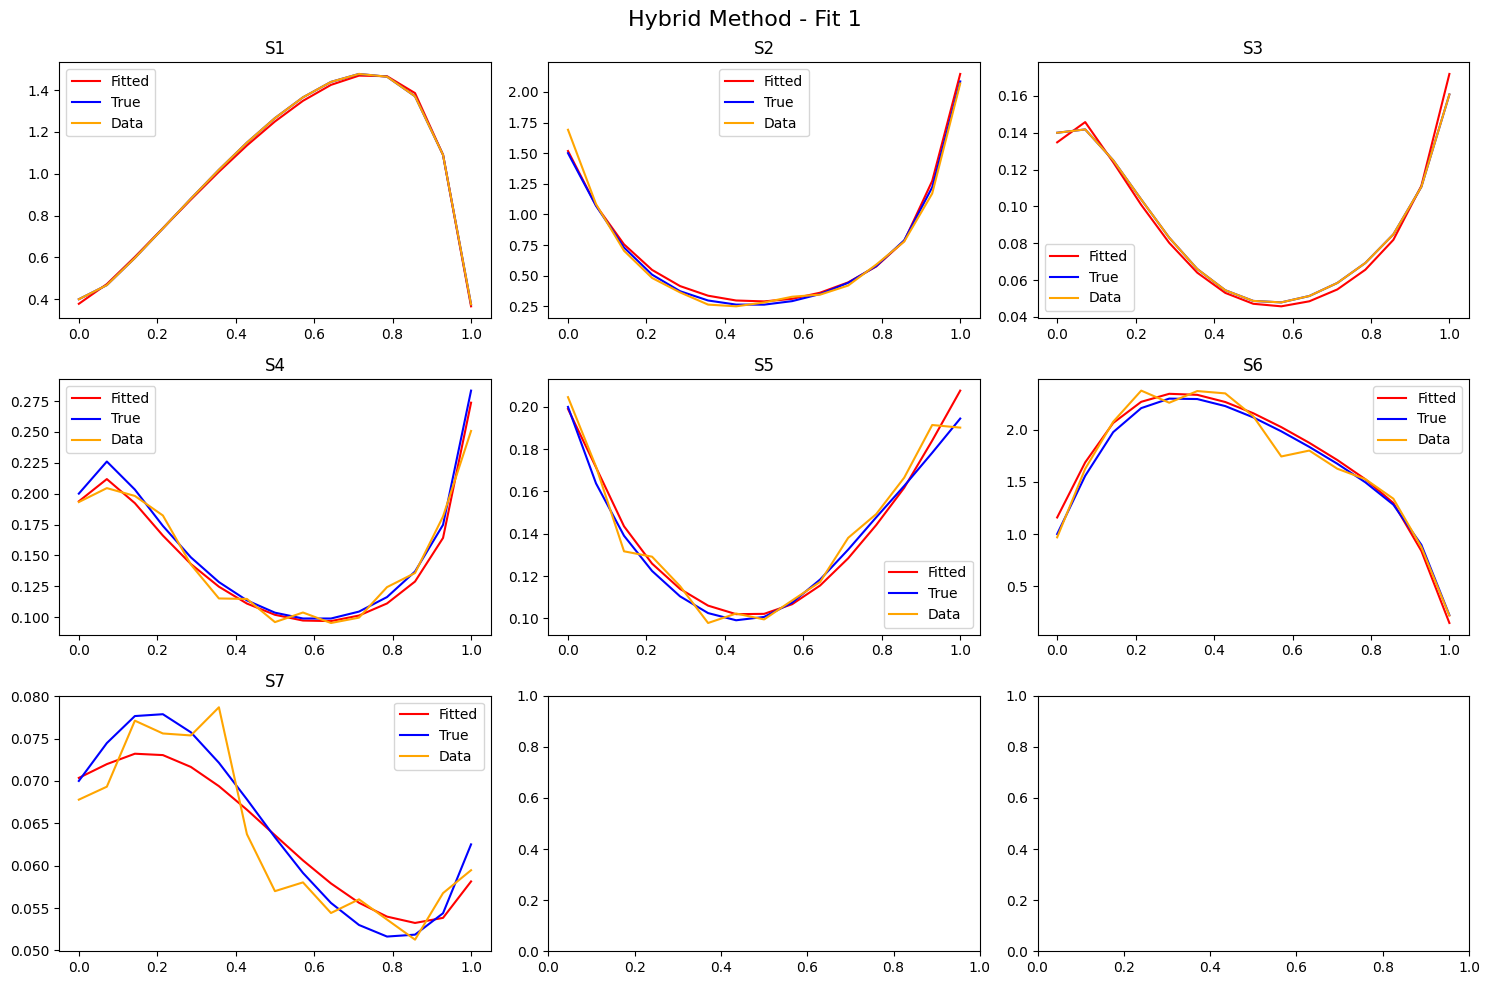

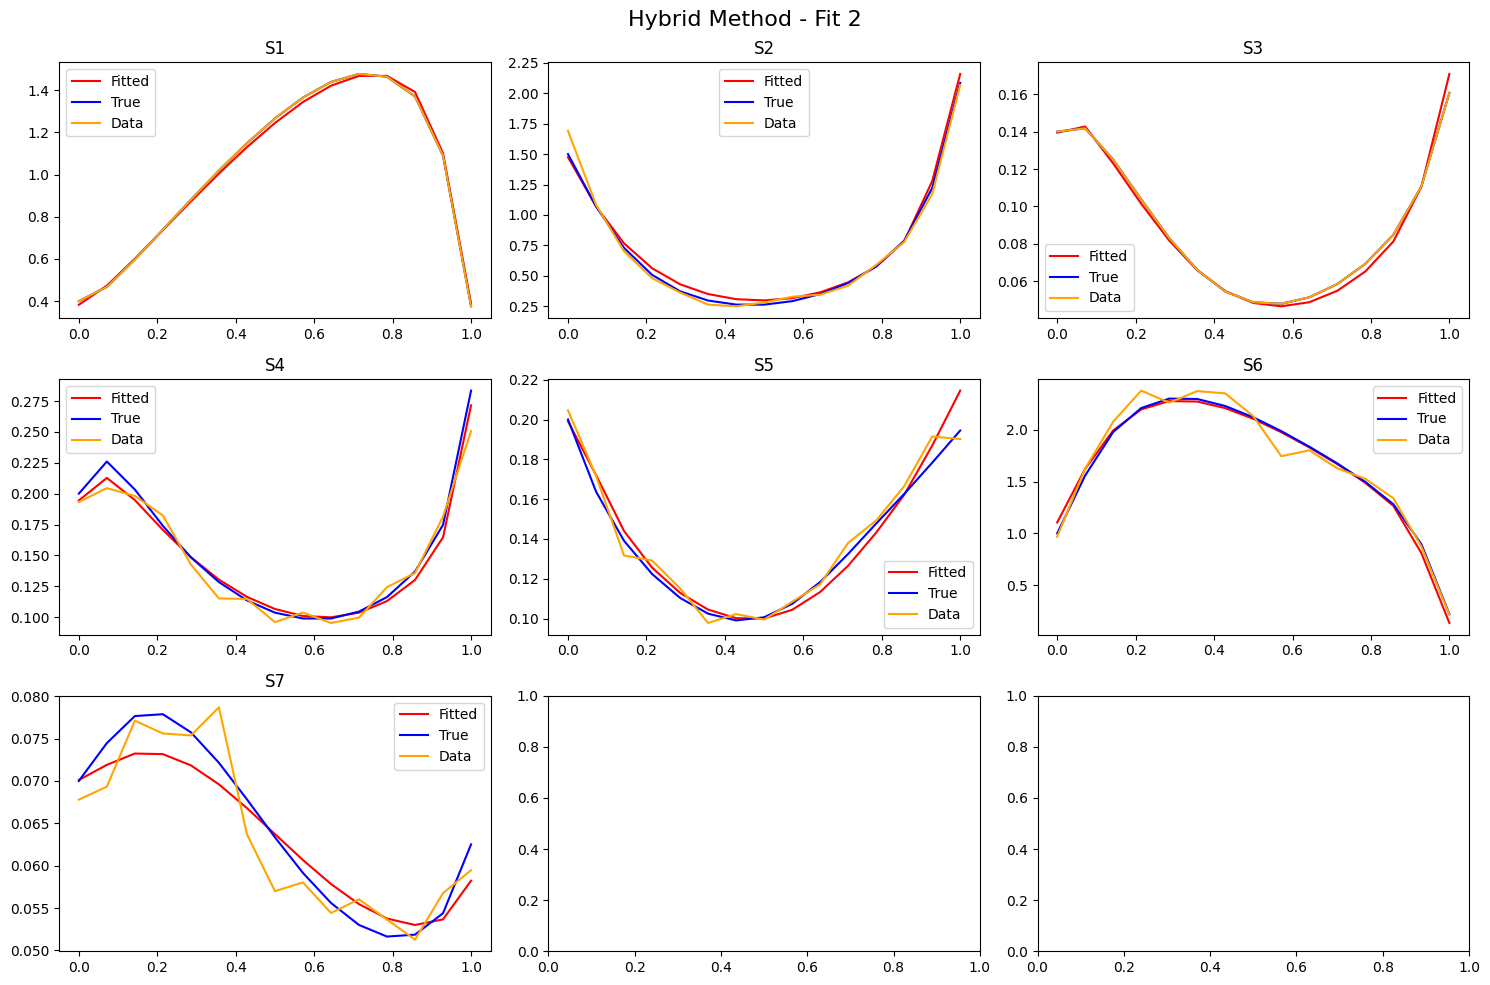

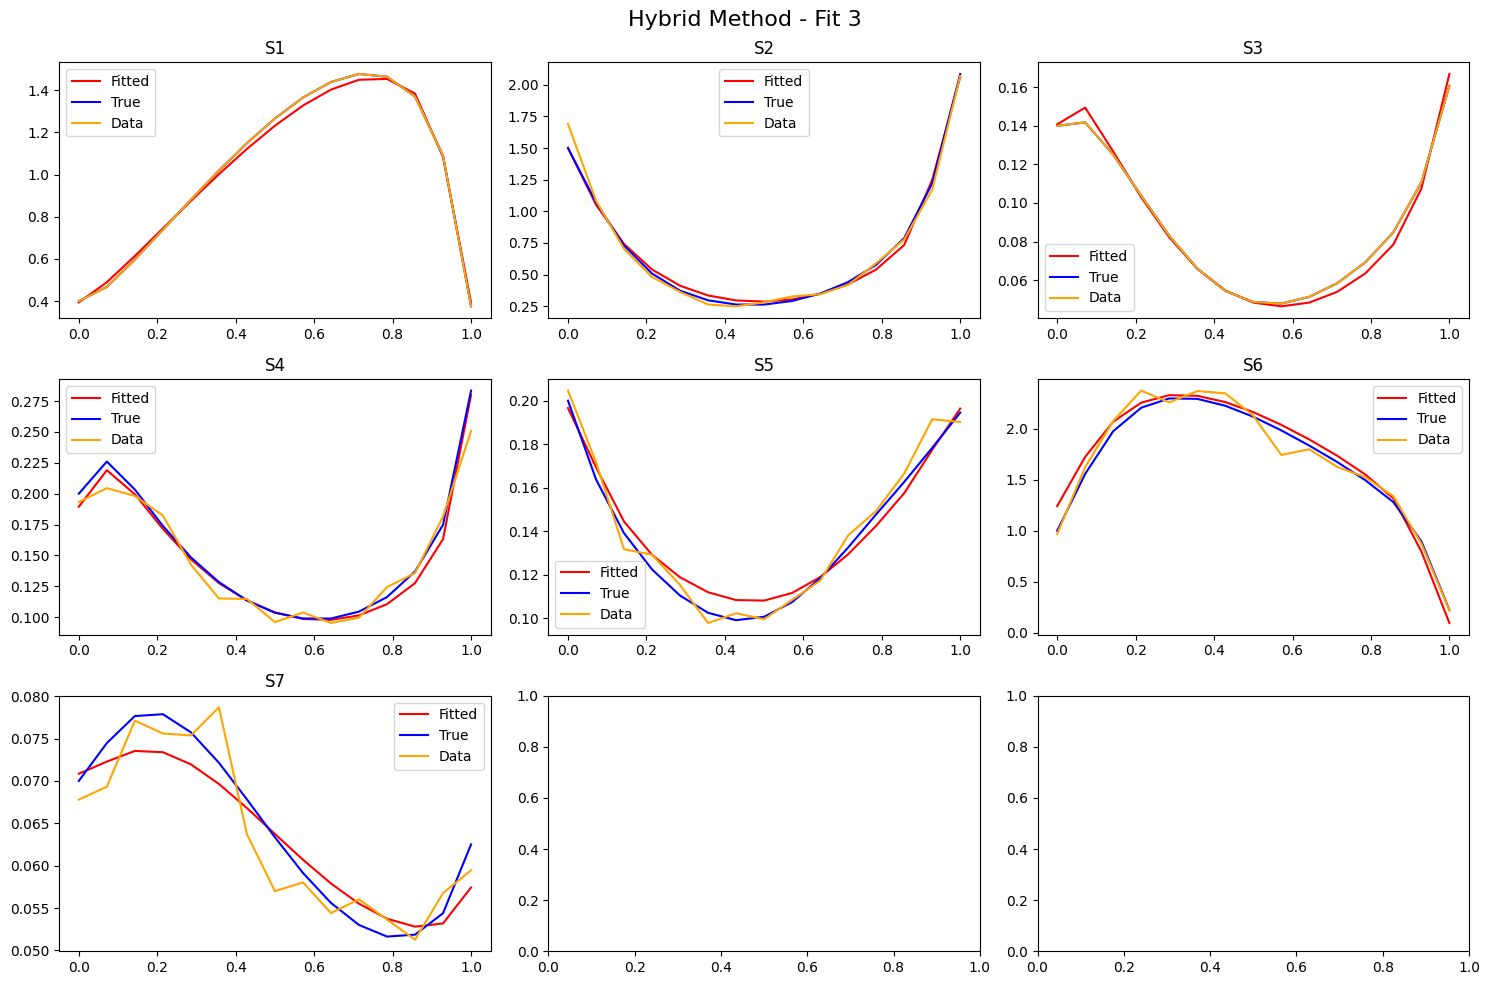

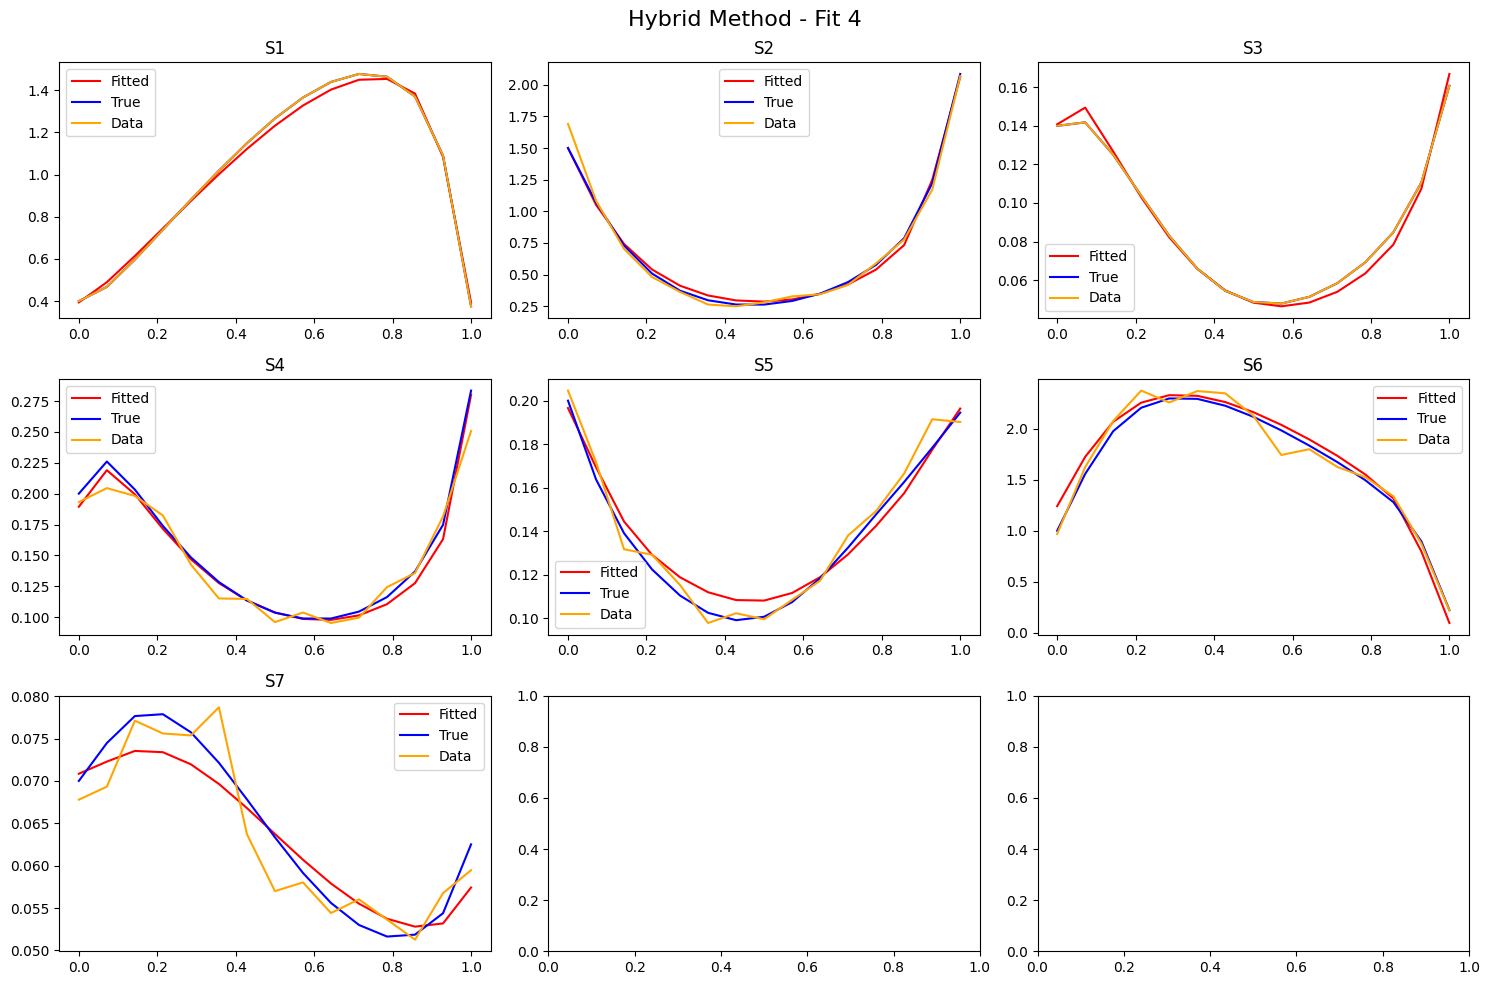

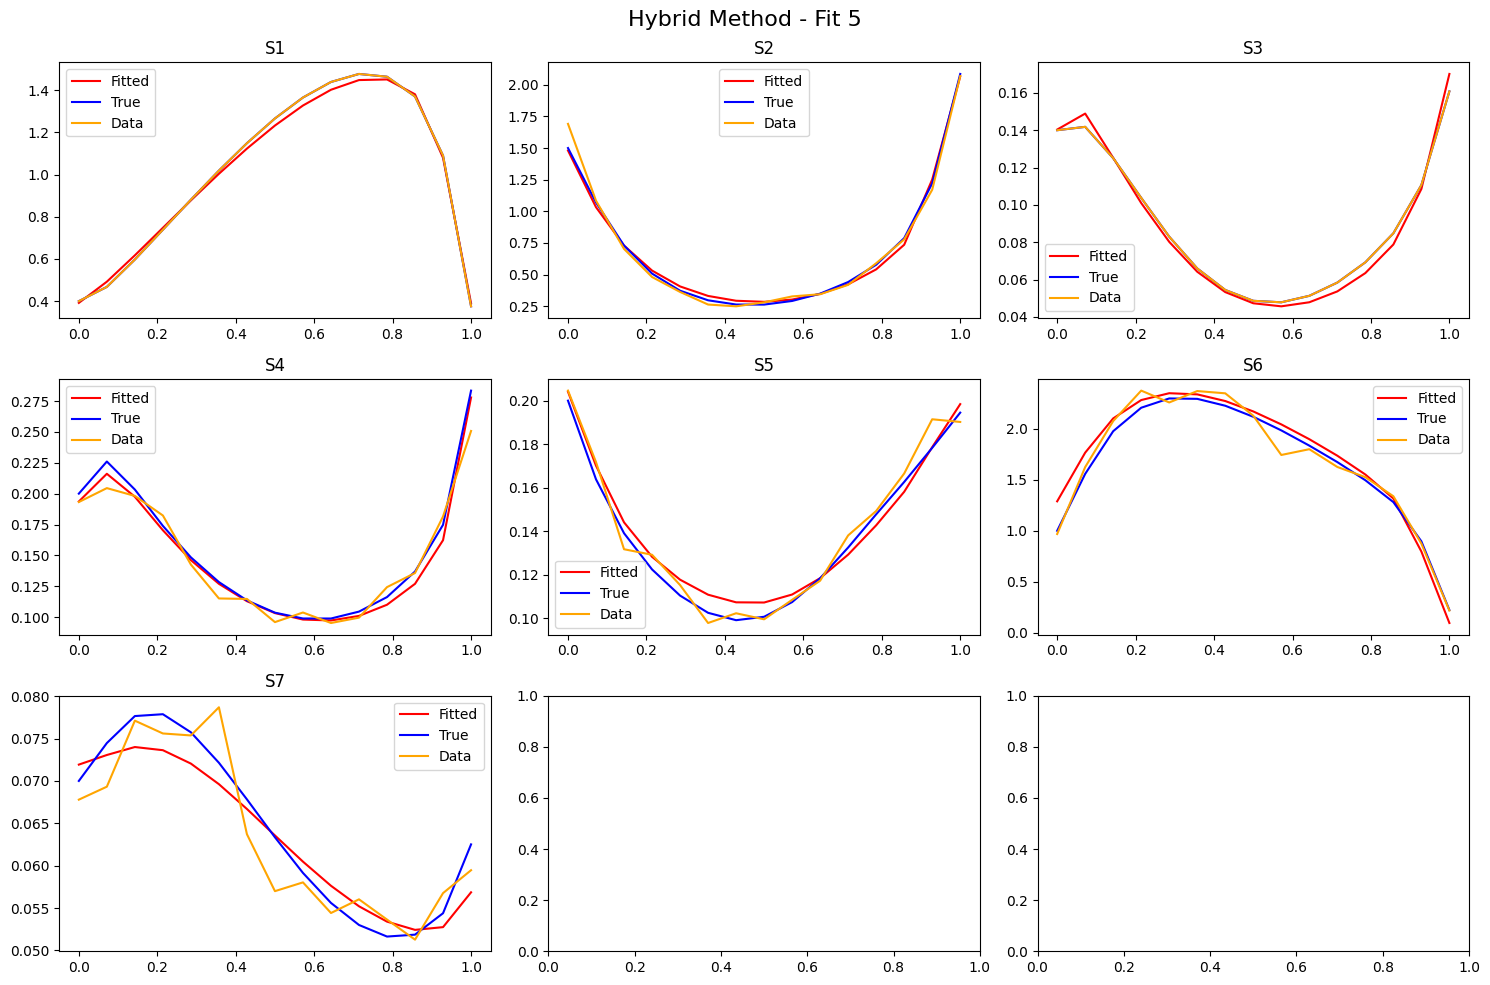

In [18]:
# [17]
# Sort the results by objective function value
sorted_hybrid_results = sorted(hybrid_results, key=lambda x: x['fun'])

# Plot the top 5 fits
for idx, result in enumerate(sorted_hybrid_results[:5]):
    plot_fit(result, 'Hybrid Method', idx)

In [19]:
# Print total execution times for all methods
print(f"Execution Times:")
print(f"Classical Method: {classical_method_time:.2f} minutes")
print(f"Innovative Method: {innovative_method_time:.2f} minutes")
print(f"Hybrid Method: {hybrid_method_time:.2f} minutes")

Execution Times:
Classical Method: 4.16 minutes
Innovative Method: 0.04 minutes
Hybrid Method: 0.34 minutes


In [20]:
# [18]
# Display per-variable fit values for the top results
def display_top_results(sorted_results, method_name):
    df_list = []
    for idx, result in enumerate(sorted_results[:10]):
        per_variable_distances = result['per_variable_distances']
        data = {'Fit Rank': idx+1, 'Total Objective': result['fun']}
        for i, var_name in enumerate(variable_names):
            data[var_name] = per_variable_distances[i]
        df_list.append(data)
    df = pd.DataFrame(df_list)
    print(f"Top 10 results for {method_name}:")
    display(df)

In [21]:
# [19]
display_top_results(sorted_results, 'Classical Method')
display_top_results(sorted_innovative_results, 'Innovative Method')
display_top_results(sorted_hybrid_results, 'Hybrid Method')

Top 10 results for Classical Method:


,Fit Rank,Total Objective,S1,S2,S3,S4,S5,S6,S7
0,1,3.572969,0.973003,0.382001,0.754382,0.394584,0.471995,0.267579,0.329426
1,2,3.582037,0.329304,0.476551,0.781248,0.617711,0.812223,0.302318,0.262682
2,3,3.965659,0.966737,0.277843,0.672298,0.434733,0.383130,0.795610,0.447356
3,4,4.697490,0.907289,0.436604,0.797776,0.781179,0.640737,0.283856,0.856077
4,5,5.755203,1.072487,0.577089,0.803009,1.068588,0.476482,0.425143,1.333765
5,6,6.300671,1.023588,0.415350,0.553954,0.705487,1.978284,1.419546,0.204572
6,7,6.724604,0.945536,0.568167,1.189514,0.255089,2.662739,0.677248,0.426974
7,8,8.207366,0.636652,0.453411,0.809234,0.615117,2.724188,1.577765,1.395187
8,9,10.011447,1.443448,0.368977,0.851184,0.822109,0.795163,1.297059,4.436106
9,10,11.074649,1.101417,0.436403,1.382696,0.873444,3.488300,2.432907,1.362601


Top 10 results for Innovative Method:


,Fit Rank,Total Objective,S1,S2,S3,S4,S5,S6,S7
0,1,1.442700,0.419510,0.190055,0.165386,0.141082,0.140911,0.244247,0.141510
1,2,1.442776,0.419536,0.190057,0.165394,0.141094,0.140921,0.244255,0.141519
2,3,1.442794,0.419535,0.190066,0.165401,0.141097,0.140927,0.244256,0.141512
3,4,1.442797,0.419535,0.190067,0.165402,0.141098,0.140928,0.244256,0.141511
4,5,1.442797,0.419535,0.190067,0.165402,0.141098,0.140928,0.244256,0.141511
5,6,1.442797,0.419535,0.190067,0.165402,0.141098,0.140928,0.244256,0.141511
6,7,1.442798,0.419535,0.190067,0.165402,0.141098,0.140928,0.244256,0.141511
7,8,1.442798,0.419535,0.190067,0.165402,0.141098,0.140928,0.244256,0.141511
8,9,1.442798,0.419535,0.190067,0.165402,0.141098,0.140928,0.244256,0.141511
9,10,1.442798,0.419535,0.190067,0.165402,0.141098,0.140928,0.244256,0.141511


Top 10 results for Hybrid Method:


,Fit Rank,Total Objective,S1,S2,S3,S4,S5,S6,S7
0,1,0.404451,0.010795,0.035656,0.034963,0.065722,0.067541,0.049082,0.141081
1,2,0.417084,0.012643,0.044139,0.029598,0.064998,0.078570,0.048534,0.138631
2,3,0.441374,0.021774,0.035473,0.033219,0.074919,0.076784,0.058939,0.140747
3,4,0.441374,0.021774,0.035473,0.033219,0.074919,0.076784,0.058939,0.140747
4,5,0.445264,0.019613,0.037921,0.038165,0.073688,0.070411,0.064869,0.141039
5,6,0.446165,0.021837,0.042578,0.029996,0.075257,0.081819,0.058173,0.137606
6,7,0.447207,0.023772,0.037895,0.031649,0.071133,0.077488,0.064764,0.141631
7,8,0.447892,0.029070,0.036825,0.045503,0.071462,0.077691,0.051871,0.137977
8,9,0.481940,0.023608,0.032236,0.063348,0.093079,0.072940,0.055776,0.141096
9,10,0.481940,0.023608,0.032236,0.063348,0.093079,0.072940,0.055776,0.141096


In [22]:
!pip install ipynbname
import json
import nbformat
from nbformat import read, write
import os
import ipynbname

def export_notebook_to_txt():
    # Get the current notebook name
    notebook_filename = ipynbname.name()
    
    # Get the full path to the notebook
    notebook_path = ipynbname.path()
    
    # Read the notebook
    with open(notebook_path, 'r', encoding='utf-8') as nb_file:
        notebook = read(nb_file, as_version=4)
    
    # Prepare content for TXT file
    notebook_content = []
    code_cell_count = 0
    for cell in notebook.cells:
        if cell.cell_type == 'code':
            code_cell_count += 1
            # cell_content = f'# [{code_cell_count}]\n'
            cell_content = cell.source
        elif cell.cell_type == 'markdown':
            cell_content = '# [MD]\n'
            cell_content += '# ' + cell.source.replace('\n', '\n# ')
        notebook_content.append(cell_content)

    # Join all cell contents
    full_content = '\n\n'.join(notebook_content)
    
    # Save to TXT file
    txt_filename = f'{notebook_filename.split(".")[0]}_content.txt'
    with open(txt_filename, 'w', encoding='utf-8') as txt_file:
        txt_file.write(full_content)

    return f"Notebook content has been exported to {txt_filename}"

# Run the function
export_notebook_to_txt()

'Notebook content has been exported to EqFit_content.txt'